# ConvNet model

Building a simple ConvNet model for multi-label classification using Keras(Luda)

Adapted from "Simple Keras Starter" Kernel from anokas on Kaggle


In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense, Dropout, Flatten
from tensorflow.contrib.keras.api.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, recall_score, make_scorer, average_precision_score
import matplotlib.pyplot as plt
import cv2
import warnings

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)


import cv2
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [3]:
# General functions from 0-baseline notebook

# Preprocess images
# Input: number of samples, dim, path
# Output: X, y, list of class names
def preprocess(n_samples, rescaled_dim, f_path ="../data/train.csv"):
    df = pd.read_csv(f_path)
    df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
    lb = MultiLabelBinarizer()
    y = lb.fit_transform(df['split_tags'])
    y = y[:n_samples]
    
    imgs = []
    # for each image, rescale to same dimension and flattern
    print "processing images..."
    count = 0
    for name in df.head(n_samples)['image_name'].values:
        raw_img = plt.imread('../data/train-jpg/{}.jpg'.format(name))
        #print raw_img
        imgs.append(cv2.resize(raw_img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1))
        count+=1
        if count % 1000 == 0:
            print count, "processed"

    # remove dimenions    
    X = np.squeeze(np.array(imgs))

    # scale X so that each feature be between 0 and 1
    X = MinMaxScaler().fit_transform(np.float32(X))
    
    return np.array(X, np.float16), np.array(y, np.uint8), lb.classes_


def optimize_threshold(X_test, y_test, model):
    prediction = model.predict(X_test)
    true_label = y_test
    best_threshhold = [0.2]*17    
    for t in range(17):
        best_fbeta = 0
        temp_threshhold = [0.2]*17
        for i in range(100):
            temp_value = i / float(100)
            temp_threshhold[t] = temp_value
            temp_fbeta = fbeta_score(true_label, prediction > temp_threshhold, beta=2, average="samples")
            if temp_fbeta > best_fbeta:
                best_fbeta = temp_fbeta
                best_threshhold[t] = temp_value
    return best_threshhold


# Using a trained model, calculate the F2_score
# input: X_test, y_test, model
# output: a list of F2_score by class(length 17)
def calc_F2_score_cnn(X_test, y_test, model, thres = 0.2, avg_mode = None, opt = False):
    if opt:
        print "Optimizing threshold..."
        thres = optimize_threshold(X_test, y_test, model)
        print "Using optimized threshold: ", thres
    predicted = np.array(model.predict(X_test)) > thres
    score = fbeta_score(y_test, predicted, beta=2, average=avg_mode)
    return score

def calc_precision_cnn(X_test, y_test, model, thres = 0.2, avg_mode = None, opt = False):
    if opt:
        print "Optimizing threshold..."
        thres = optimize_threshold(X_test, y_test, model)
        print "Using optimized threshold: ", thres
    predicted = np.array(model.predict(X_test)) > thres
    score = precision_score(y_test, predicted, average=avg_mode)
    return score

def calc_recall_cnn(X_test, y_test, model, thres = 0.2, avg_mode = None, opt = False):
    if opt:
        print "Optimizing threshold..."
        thres = optimize_threshold(X_test, y_test, model)
        print "Using optimized threshold: ", thres
    predicted = np.array(model.predict(X_test)) > thres
    score = recall_score(y_test, predicted, average=avg_mode)
    return score

    
def print_results(scores, ind_to_classes):
    # print the scores with the classes
    results = [(ind_to_classes[l], scores[l]) for l in scores.argsort()[::-1]]
    print "************************RESULTS************************"
    for res in results:
        print res[0], res[1]
    print "************************END RESULTS************************"
    
# define cross validation
# if fold = 1 just use a 20% test set
# Training model func: need to take in X_train, y_train, and initial model(if necessary)
def cross_validation_train_score(X, y, train_model_func, scoring_func, folds=10):

    if folds == 1:
        print "Using a 20% test set..."
        print "X shape:", X.shape
        print "y shape:", y.shape
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
        model = train_model_func(X_train, y_train)
        score = scoring_func(X_test, y_test, model)
        return model, np.array(score)

    print "Using cross validation with folds", folds
    print "X shape:", X.shape
    print "y shape:", y.shape    
    kf = KFold(n_splits=folds, shuffle=True)
    scores_all = []
    for ind, (train, test) in enumerate(kf.split(X)):
        print "Fold ", ind
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        model = train_model_func(X_train, y_train)
        score = scoring_func(X_test, y_test, model)
        scores_all.append(score)
        
    return model, np.mean(np.array(scores_all), axis=0), None

In [4]:
# CNN specific preprocessing function, creating 4 dimensional input vectors
def preprocess_cnn(n_samples, rescaled_dim, f_path ="../data/train.csv"):
    df = pd.read_csv(f_path)
    df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
    lb = MultiLabelBinarizer()
    y = lb.fit_transform(df['split_tags'])
    y = y[:n_samples]
    
    imgs = []
    # for each image, rescale to same dimension and flattern
    print "processing images..."
    count = 0
    for name in df.head(n_samples)['image_name'].values:
        raw_img = plt.imread('../data/train-jpg/{}.jpg'.format(name))
        #print raw_img
        imgs.append(cv2.resize(raw_img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)[:, :, :3])
        count+=1
        if count % 1000 == 0:
            print count, "processed"

    # remove dimenions, normalize  
    X = np.squeeze(np.array(imgs)) / 255.

    return np.array(X, np.float16), np.array(y, np.uint8), lb.classes_



# Define model architecture

In [9]:
def train_cnn_model_1(x_train, y_train):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(32, 32, 3)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=64,
              epochs=5,
              verbose=1)
    return model

# Train the model!

In [5]:
NUM_TRAIN = 40482
NUM_SAMPLE = NUM_TRAIN
DIM = 32
X, y, ind_to_classes = preprocess_cnn(NUM_SAMPLE, DIM, "../data/train.csv")
print X.shape, y.shape

processing images...
1000 processed
2000 processed
3000 processed
4000 processed
5000 processed
6000 processed
7000 processed
8000 processed
9000 processed
10000 processed
11000 processed
12000 processed
13000 processed
14000 processed
15000 processed
16000 processed
17000 processed
18000 processed
19000 processed
20000 processed
21000 processed
22000 processed
23000 processed
24000 processed
25000 processed
26000 processed
27000 processed
28000 processed
29000 processed
30000 processed
31000 processed
32000 processed
33000 processed
34000 processed
35000 processed
36000 processed
37000 processed
38000 processed
39000 processed
40000 processed
(40479, 32, 32, 3) (40479, 17)


In [108]:
model, cv_f2_scores = cross_validation_train_score(X, y, train_cnn_model_1, calc_F2_score_cnn, 1) #no cross-validation
print_results(cv_f2_scores, ind_to_classes)

Using a 20% test set...
X shape: (40479, 32, 32, 3)
y shape: (40479, 17)
Epoch 1/5
32383/32383 [==============================] - 78s - loss: 0.2342 - acc: 0.9103    
Epoch 2/5
32383/32383 [==============================] - 78s - loss: 0.1947 - acc: 0.9237    
Epoch 3/5
32383/32383 [==============================] - 78s - loss: 0.1844 - acc: 0.9280    
Epoch 4/5
32383/32383 [==============================] - 77s - loss: 0.1773 - acc: 0.9308    
Epoch 5/5
32383/32383 [==============================] - 79s - loss: 0.1708 - acc: 0.9336    
************************RESULTS************************
primary 0.987326887902
clear 0.95884620587
agriculture 0.812865085509
partly_cloudy 0.787007318013
road 0.73715675347
cloudy 0.670297444491
haze 0.609621740727
water 0.604987684729
habitation 0.571746384872
cultivation 0.404491931967
artisinal_mine 0.387409200969
bare_ground 0.0298329355609
slash_burn 0.0
conventional_mine 0.0
selective_logging 0.0
blow_down 0.0
blooming 0.0
***********************

In [ ]:
model, cv_f2_scores = cross_validation_train_score(X, y, train_cnn_model_1, calc_precision_score_cnn, 1) #no cross-validation


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # use the same split

In [109]:
#save model at a location
import datetime
def timestamp():
    return '{:%m%d_%H_%M_%s}'.format(datetime.datetime.now())

fn = "../data/cnn-1_" + timestamp() + '.h5'
model.save(fn)

# Train a better model
we will use a deeping network with more validation to train our data

In [39]:

def train_cnn_model_2(X, y):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(32, 32, 3)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer='adam',
                  metrics=['accuracy'])

    X_train, X_valid, Y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=0)
    
    model.fit(X_train, Y_train,
              batch_size=64,
              validation_data=(X_valid, y_valid),
              epochs=5,
              verbose=1)
    return model

In [40]:
model, cv_f2_scores = cross_validation_train_score(X, y, train_cnn_model_2, calc_F2_score_cnn, 1) #no cross-validation
print_results(cv_f2_scores, ind_to_classes)

Using a 20% test set...
X shape: (40479, 32, 32, 3)
y shape: (40479, 17)
Train on 25906 samples, validate on 6477 samples
Epoch 1/5
25906/25906 [==============================] - 88s - loss: 0.2755 - acc: 0.9003 - val_loss: 0.2322 - val_acc: 0.9082
Epoch 2/5
25906/25906 [==============================] - 88s - loss: 0.1711 - acc: 0.9327 - val_loss: 0.1558 - val_acc: 0.9385
Epoch 3/5
25906/25906 [==============================] - 87s - loss: 0.1627 - acc: 0.9355 - val_loss: 0.1502 - val_acc: 0.9403
Epoch 4/5
25906/25906 [==============================] - 87s - loss: 0.1555 - acc: 0.9384 - val_loss: 0.1445 - val_acc: 0.9430
Epoch 5/5
25906/25906 [==============================] - 88s - loss: 0.1496 - acc: 0.9404 - val_loss: 0.1388 - val_acc: 0.9447
************************RESULTS************************
primary 0.986326584276
clear 0.968411143266
partly_cloudy 0.887219081759
agriculture 0.839625381153
cloudy 0.839173736629
road 0.754959399733
haze 0.709866492999
water 0.619363251114
habi

/home/luda/cs231a-human-footprint/.env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
#save model at a location
import datetime
def timestamp():
    return '{:%m%d_%H_%M_%s}'.format(datetime.datetime.now())

fn = "../data/cnn-2_" + timestamp() + '.h5'
model.save(fn)

In [1]:
# load model code

from keras.models import load_model
model = load_model('../data/cnn-2_0530_03_48_1496116132.h5')

Using TensorFlow backend.


In [14]:
print_results(calc_F2_score_cnn(X_test, y_test, model, thres = 0.2, avg_mode = None), ind_to_classes)

************************RESULTS************************
primary 0.987607519151
clear 0.971716605993
partly_cloudy 0.904660168247
agriculture 0.835785756327
cloudy 0.826171875
road 0.752772546558
haze 0.729513657562
water 0.601987802123
habitation 0.589714285714
cultivation 0.525946704067
artisinal_mine 0.301003344482
slash_burn 0.0
conventional_mine 0.0
selective_logging 0.0
blow_down 0.0
blooming 0.0
bare_ground 0.0
************************END RESULTS************************


/home/luda/cs231a-human-footprint/.env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
calc_F2_score_cnn(X_test, y_test, model, thres = 0.2, avg_mode = "samples")

0.87721270692453734

In [52]:
#load old model for comparison

from keras.models import load_model
old_model = load_model('../data/cnn-1_0515_01_45_1494812710.h5')

In [53]:
calc_F2_score_cnn(X_test, y_test, old_model, thres = 0.2, avg_mode = "samples")

0.84912731172290057

# Optimize F2 threshold

In [16]:

def optimize_threshold(X_test, y_test, model):
    prediction = model.predict(X_test)
    true_label = y_test
    best_threshhold = [0.2]*17    
    for t in range(17):
        best_fbeta = 0
        temp_threshhold = [0.2]*17
        for i in range(1000):
            temp_value = i / float(1000)
            temp_threshhold[t] = temp_value
            temp_fbeta = fbeta_score(true_label, prediction > temp_threshhold, beta=2, average="samples")
            if temp_fbeta > best_fbeta:
                best_fbeta = temp_fbeta
                best_threshhold[t] = temp_value
        print best_threshhold
    return best_threshhold


# Using a trained model, calculate the F2_score
# input: X_test, y_test, model
# output: a list of F2_score by class(length 17)
def calc_F2_score_cnn(X_test, y_test, model, thres = 0.2, avg_mode = None, opt = False):
    if opt:
        print "Optimizing threshold..."
        thres = optimize_threshold(X_test, y_test, model)
        print "Using optimized threshold: ", thres
    predicted = np.array(model.predict(X_test)) > thres
    score = fbeta_score(y_test, predicted, beta=2, average=avg_mode)
    return score

In [62]:
calc_F2_score_cnn(X_test, y_test, model, thres = 0.2, avg_mode = "samples", opt=True)

Optimizing threshold...
[0.242, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.016, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.016, 0.131, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.016, 0.131, 0.138, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.016, 0.131, 0.138, 0.044, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.016, 0.131, 0.138, 0.044, 0.152, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.016, 0.131, 0.138, 0.044, 0.152, 0.207, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[0.242, 0.065, 0.1, 0.03, 0.0

0.8808465190650645

In [64]:
best_thres = [0.242, 0.065, 0.1, 0.03, 0.016, 0.131, 0.138, 0.044, 0.152, 0.207, 0.277, 0.174, 0.207, 0.18, 0.059, 0.058, 0.217]
print_results(calc_F2_score_cnn(X_test, y_test, model, thres = best_thres, avg_mode = None), ind_to_classes)

************************RESULTS************************
primary 0.987683376481
clear 0.972594630358
partly_cloudy 0.906611680192
agriculture 0.8375065401
cloudy 0.820165537998
road 0.759159594287
haze 0.72529782761
cultivation 0.593506032647
water 0.591663723066
habitation 0.590624274774
artisinal_mine 0.543209876543
bare_ground 0.260469867211
selective_logging 0.0326797385621
slash_burn 0.0
conventional_mine 0.0
blow_down 0.0
blooming 0.0
************************END RESULTS************************


# Add in PHOG features

In [17]:
'''
Code credit: http://www.robots.ox.ac.uk/~vgg/research/caltech/phog.html
'''
class PHogFeatures():
    '''
    Computes a PHOG descriptor of an image.
    '''

    def __init__(self):
        pass

    def get_features(self, image_path, bins=9, angle=360., pyramid_levels=3):
        """
        Returns a feature vector containing a PHOG descriptor of a whole image.

        :param image_path: Absolute path to an image
        :param bins: Number of (orientation) bins on the histogram (optimal: 20)
        :param angle: 180 or 360 (optimal: 360)
        :param pyramid_levels: Number of pyramid levels (optimal: 3)
        :return:
        """

        feature_vec = self.phog(image_path, bins, angle, pyramid_levels)
        feature_vec = feature_vec.T[0]  # Transpose vector, take the first array
        return feature_vec

    def phog(self, image_path, bin, angle, pyramid_levels):
        """
        Given and image I, phog computes the Pyramid Histogram of Oriented
        Gradients over L pyramid levels and over a Region Of Interest.

        :param image_path: Absolute path to an image of size MxN (Color or Gray)
        :param bin: Number of (orientation) bins on the histogram
        :param angle: 180 or 360
        :param pyramid_levels: Number of pyramid levels
        :return: Pyramid histogram of oriented gradients
        """

        grayscale_img = cv2.imread(image_path, 0)  # 0 converts it to grayscale

        bh = np.array([])
        bv = np.array([])
        if np.sum(np.sum(grayscale_img)) > 100.:
            # Matlab The default sigma is sqrt(2); the size of the filter is chosen automatically, based on sigma.
            # Threshold is applied automatically - the percentage is a bit different than in Matlab's implementation:
            # low_threshold: 10%
            # high_threshold: 20%
            edges_canny = feature.canny(grayscale_img, sigma=math.sqrt(2))
            [GradientY, GradientX] = np.gradient(np.double(grayscale_img))
            GradientYY = np.gradient(GradientY)[1]  # Take only the first matrix
            Gr = np.sqrt((GradientX * GradientX + GradientY * GradientY))

            index = GradientX == 0.
            index = index.astype(int)  # Convert boolean array to an int array
            GradientX[np.where(index > 0)] = np.power(10, -5)
            YX = GradientY / GradientX

            if angle == 180.:
                angle_values = np.divide((np.arctan(YX) + np.pi / 2.) * 180., np.pi)
            if angle == 360.:
                angle_values = np.divide((np.arctan2(GradientY, GradientX) + np.pi) * 180., np.pi)

            [bh, bv] = self.bin_matrix(angle_values, edges_canny, Gr, angle, bin)
        else:
            bh = np.zeros(image_path.shape[0], image_path.shape[1])
            bv = np.zeros(image_path.shape[0], image_path.shape[1])

        # Don't consider a roi, take the whole image instead
        bh_roi = bh
        bv_roi = bv
        p = self.phog_descriptor(bh_roi, bv_roi, pyramid_levels, bin)

        return p

    def bin_matrix(self, angle_values, edge_image, gradient_values, angle, bin):
        """
        Computes a Matrix (bm) with the same size of the image where
        (i,j) position contains the histogram value for the pixel at position (i,j)
        and another matrix (bv) where the position (i,j) contains the gradient
        value for the pixel at position (i,j)

        :param angle_values: Matrix containing the angle values
        :param edge_image: Edge Image
        :param gradient_values: Matrix containing the gradient values
        :param angle: 180 or 360
        :param bin: Number of bins on the histogram
        :return: bm - Matrix with the histogram values
                bv - Matrix with the gradient values (only for the pixels belonging to and edge)
        """

        # 8-orientations/connectivity structure (Matlab's default is 8 for bwlabel)
        structure_8 = [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]

        [contorns, n] = ndimage.label(edge_image, structure_8)
        X = edge_image.shape[1]
        Y = edge_image.shape[0]
        bm = np.zeros((Y, X))
        bv = np.zeros((Y, X))
        nAngle = np.divide(angle, bin)
        for i in np.arange(1, n + 1):
            [posY, posX] = np.nonzero(contorns == i)
            posY = posY + 1
            posX = posX + 1
            for j in np.arange(1, (posY.shape[0]) + 1):
                pos_x = posX[int(j) - 1]
                pos_y = posY[int(j) - 1]
                b = np.ceil(np.divide(angle_values[int(pos_y) - 1, int(pos_x) - 1], nAngle))
                if b == 0.:
                    bin = 1.
                if gradient_values[int(pos_y) - 1, int(pos_x) - 1] > 0:
                    bm[int(pos_y) - 1, int(pos_x) - 1] = b
                    bv[int(pos_y) - 1, int(pos_x) - 1] = gradient_values[int(pos_y) - 1, int(pos_x) - 1]

        return [bm, bv]

    def phog_descriptor(self, bh, bv, pyramid_levels, bin):
        """
        Computes Pyramid Histogram of Oriented Gradient over an image.

        :param bh: Matrix of bin histogram values
        :param bv: Matrix of gradient values
        :param pyramid_levels: Number of pyramid levels
        :param bin: Number of bins
        :return: Pyramid histogram of oriented gradients (phog descriptor)
        """

        p = np.empty((0, 1), dtype=int)  # dtype=np.float64? # vertical size 0, horizontal 1

        for b in np.arange(1, bin + 1):
            ind = bh == b
            ind = ind.astype(int)  # convert boolean array to int array
            sum_ind = np.sum(bv[np.where(ind > 0)])
            p = np.append(p, np.array([[sum_ind]]), axis=0)  # append the sum horizontally to empty p array

        cella = 1.
        for l in np.arange(1, pyramid_levels + 1):  # defines a range (from, to, step)
            x = np.fix(np.divide(bh.shape[1], 2. ** l))
            y = np.fix(np.divide(bh.shape[0], 2. ** l))
            xx = 0.
            yy = 0.
            while xx + x <= bh.shape[1]:
                while yy + y <= bh.shape[0]:
                    bh_cella = np.array([])
                    bv_cella = np.array([])
                    bh_cella = bh[int(yy + 1.) - 1:yy + y, int(xx + 1.) - 1:xx + x]
                    bv_cella = bv[int(yy + 1.) - 1:yy + y, int(xx + 1.) - 1:xx + x]

                    for b in np.arange(1, bin + 1):
                        ind = bh_cella == b
                        ind = ind.astype(int)  # convert boolean array to int array
                        sum_ind = np.sum(bv_cella[np.where(ind > 0)])
                        p = np.append(p, np.array([[sum_ind]]), axis=0)  # append the sum horizontally to p

                    yy = yy + y

                cella = cella + 1.
                yy = 0.
                xx = xx + x

        if np.sum(p) != 0:
            p = np.divide(p, np.sum(p))

        return p

In [19]:
def preprocess_phog(n_samples, rescaled_dim, f_path ="../data/train.csv"):
    df = pd.read_csv(f_path)
    df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
    lb = MultiLabelBinarizer()
    y = lb.fit_transform(df['split_tags'])
    y = y[:n_samples]
    
    features = []
    pixels_in_cell = 8
    cells_in_block = 2
    nbins = 9
    
    features = []
    # for each image, rescale to same dimension and flattern
    print "processing images..."
    count = 0
    for name in df.head(n_samples)['image_name'].values:
        phog = PHogFeatures()
        raw_img = plt.imread('../data/train-jpg/{}.jpg'.format(name))
        #print raw_img
        raw_img = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
        im_edges = cv2.Canny(raw_img, 10, 100)
        phog_feat = phog.get_features('../data/train-jpg/{}.jpg'.format(name))
        combined_feat = np.append(hog_feat.reshape(1, -1), raw_img.reshape(1, -1))
        features.append(combined_feat.reshape(1, -1))
        count+=1
        if count % 1000 == 0:
            print count, "processed"

    return np.array(X, np.float16), np.array(y, np.uint8), lb.classes_

In [ ]:
NUM_TRAIN = 40482
NUM_SAMPLE = NUM_TRAIN
DIM = 32
X_phog, _, ind_to_classes = preprocess_phog(NUM_SAMPLE, DIM, "../data/train.csv")
print X_phog.shape, y.shape

# Train a model with bigger size(Incomplete)

In [4]:
def train_cnn_model_3(X, y):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64, 64, 3)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer='adam',
                  metrics=['accuracy'])

    X_train, X_valid, Y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=0)
    
    model.fit(X_train, Y_train,
              batch_size=64,
              validation_data=(X_valid, y_valid),
              epochs=10,
              verbose=1)
    return model

In [7]:
NUM_TRAIN = 40482
NUM_SAMPLE = NUM_TRAIN
DIM = 64
X, y, ind_to_classes = preprocess_cnn(NUM_SAMPLE, DIM, "../data/train.csv")
print X.shape, y.shape

processing images...
1000 processed
2000 processed
3000 processed
4000 processed
5000 processed
6000 processed
7000 processed
8000 processed
9000 processed
10000 processed
11000 processed
12000 processed
13000 processed
14000 processed
15000 processed
16000 processed
17000 processed
18000 processed
19000 processed
20000 processed
21000 processed
22000 processed
23000 processed
24000 processed
25000 processed
26000 processed
27000 processed
28000 processed
29000 processed
30000 processed
31000 processed
32000 processed
33000 processed
34000 processed
35000 processed
36000 processed
37000 processed
38000 processed
39000 processed
40000 processed
(40479, 64, 64, 3) (40479, 17)


In [ ]:
model, cv_f2_scores = cross_validation_train_score(X, y, train_cnn_model_3, calc_F2_score_cnn, 1) #no cross-validation
print_results(cv_f2_scores, ind_to_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
calc_F2_score_cnn(X_test, y_test, model, thres = None, avg_mode = "samples", opt=True)

# Visualize Filters

In [38]:
#load model

from keras.models import load_model
model = load_model('../data/cnn-2_0530_03_48_1496116132.h5')

In [23]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)


from vis.utils import utils
from vis.visualization import visualize_activation, get_num_filters

Populating the interactive namespace from numpy and matplotlib


In [10]:
for idx, layer in enumerate(model.layers):
    print idx, layer.name 

0 batch_normalization_7
1 conv2d_19
2 conv2d_20
3 max_pooling2d_10
4 dropout_13
5 conv2d_21
6 conv2d_22
7 max_pooling2d_11
8 dropout_14
9 conv2d_23
10 conv2d_24
11 max_pooling2d_12
12 dropout_15
13 flatten_2
14 dense_6
15 batch_normalization_8
16 dropout_16
17 dense_7


In [5]:
# import numpy as np
# from matplotlib import pyplot as plt

# %matplotlib inline

# from vis.utils import utils
# from vis.utils.vggnet import VGG16
# from vis.visualization import visualize_activation, get_num_filters

# # Build the VGG16 network with ImageNet weights
# model = VGG16(weights='imagenet', include_top=True)
# print('Model loaded.')

# # The name of the layer we want to visualize
# # (see model definition in vggnet.py)
# layer_name = 'block1_conv2'
# layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

Model loaded.


In [29]:
layer_name = "conv2d_19"
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]
filters = np.arange(get_num_filters(model.layers[layer_idx]))

print filters

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


Working on filters: [0]
Working on filters: [1]
Working on filters: [2]
Working on filters: [3]
Working on filters: [4]
Working on filters: [5]
Working on filters: [6]
Working on filters: [7]
Working on filters: [8]
Working on filters: [9]
Working on filters: [10]
Working on filters: [11]
Working on filters: [12]
Working on filters: [13]
Working on filters: [14]
Working on filters: [15]
Working on filters: [16]
Working on filters: [17]
Working on filters: [18]
Working on filters: [19]
Working on filters: [20]
Working on filters: [21]
Working on filters: [22]
Working on filters: [23]
Working on filters: [24]
Working on filters: [25]
Working on filters: [26]
Working on filters: [27]
Working on filters: [28]
Working on filters: [29]
Working on filters: [30]
Working on filters: [31]


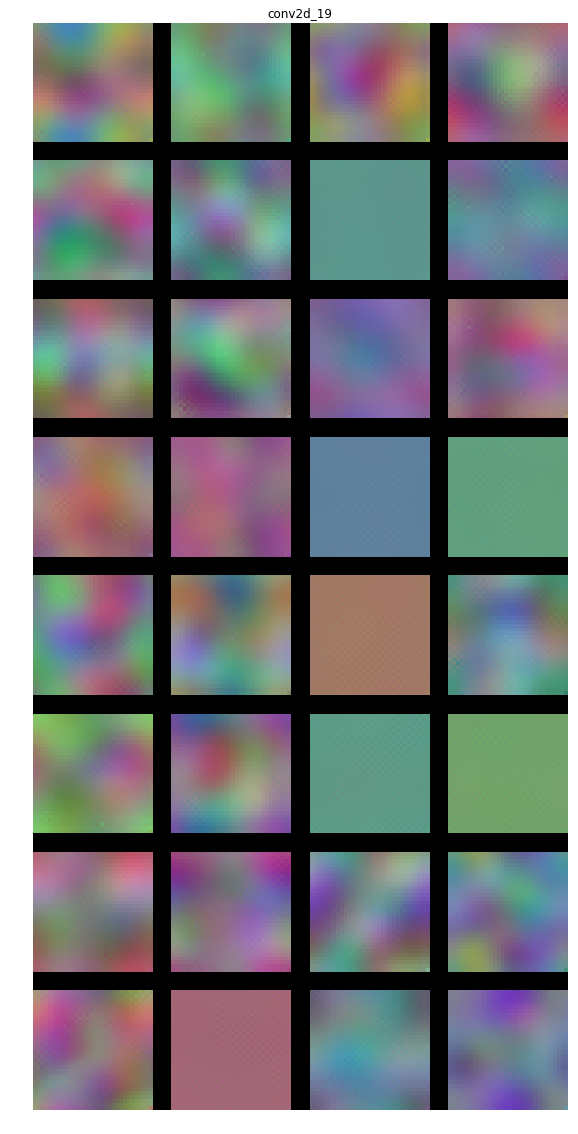

In [30]:
# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter. Here `text` field is used to overlay `filter_value` on top of the image.
vis_images = []
for idx in filters[:32]:
    img = visualize_activation(model, layer_idx, filter_indices=idx) 
    #img = utils.draw_text(img, str(idx))
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=4)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

0.720921
agriculture clear habitation primary road
Working on filters: [13]
0.391934
agriculture clear primary road water
Working on filters: [13]
0.358913
agriculture clear primary road
Working on filters: [13]
0.806069
agriculture clear cultivation primary road
Working on filters: [13]
0.799815
agriculture clear habitation primary road water
Working on filters: [13]
0.523574
agriculture clear cultivation primary road
Working on filters: [13]
0.506509
agriculture clear primary road
Working on filters: [13]
0.0788394
agriculture habitation haze primary road
Working on filters: [13]
0.101245
agriculture partly_cloudy primary road
Working on filters: [13]
0.917392
agriculture clear habitation primary road
Working on filters: [13]


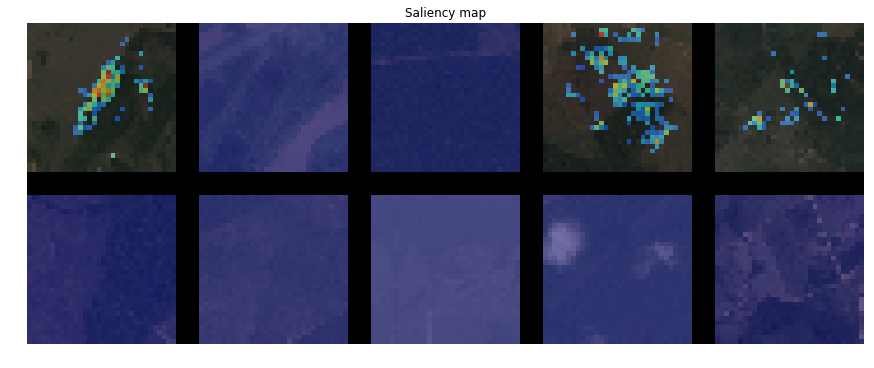

In [89]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_saliency

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'dense_7'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

n_samples = 100

# Read in data
f_path ="../data/train.csv"
df = pd.read_csv(f_path)
df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]

#seed_img = utils.load_img(path, target_size=(64, 64))
#x = np.expand_dims(img_to_array(seed_img), axis=0)
#x = preprocess_input(x)   

IND = 13 # road

heatmaps=[]
count = 0
for name, tags in df.sample(n_samples)[['image_name', 'tags']].values:
    raw_img = plt.imread('../data/train-jpg/{}.jpg'.format(name))

    #print raw_img
    img = cv2.resize(raw_img, (32, 32), cv2.INTER_LINEAR)[:, :, :3]
    # remove dimenions, normalize  
    x = np.expand_dims(np.squeeze(np.array(img)) / 255., axis=0)
    pred = model.predict(x)[0][IND]
    if lb.classes_[IND] in tags: # corrected classified   
        print pred
        print tags
        # Here we are asking it to show attention such that prob of `pred_class` is maximized.
        heatmap = visualize_saliency(model, layer_idx, [IND], img)
        heatmaps.append(heatmap)
        count+=1
        if count == 10:    
            break

plt.axis('off')
plt.imshow(utils.stitch_images(heatmaps))
plt.title('Saliency map')
plt.show()

In [72]:
for i, a in enumerate(lb.classes_):
    print i, a

0 agriculture
1 artisinal_mine
2 bare_ground
3 blooming
4 blow_down
5 clear
6 cloudy
7 conventional_mine
8 cultivation
9 habitation
10 haze
11 partly_cloudy
12 primary
13 road
14 selective_logging
15 slash_burn
16 water


Working on filters: [0]
Working on filters: [1]
Working on filters: [2]
Working on filters: [3]
Working on filters: [4]
Working on filters: [5]
Working on filters: [6]
Working on filters: [7]
Working on filters: [8]
Working on filters: [9]
Working on filters: [10]
Working on filters: [11]
Working on filters: [12]
Working on filters: [13]
Working on filters: [14]
Working on filters: [15]
Working on filters: [16]


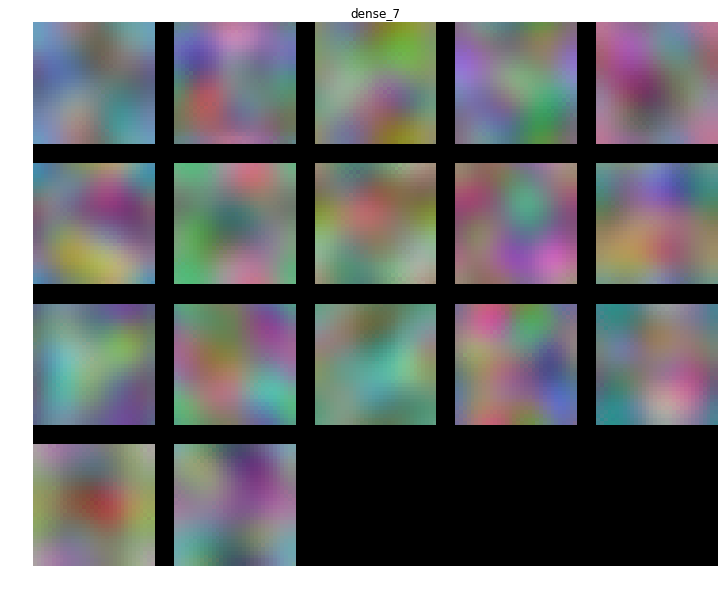

In [88]:
from vis.utils import utils
from vis.visualization import visualize_activation


# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'dense_7'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

# Generate three different images of the same output index.
vis_images = []
for idx in range(17):
    img = visualize_activation(model, layer_idx, filter_indices=idx, max_iter=500)
    #img = utils.draw_text(img, str(idx))
    vis_images.append(img)

stitched = utils.stitch_images(vis_images)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()